## import libraries 

In [24]:
import pandas
import configparser
import psycopg2

In [25]:
config = configparser.ConfigParser()
config.read('config.ini')

host = config['myaws']['host']
db = config['myaws']['db']
user = config['myaws']['user']
pwd = config['myaws']['pwd']

In [26]:
conn = psycopg2.connect(host = host,
                       user = user,
                        password = pwd,
                        dbname = db
                       )
cur = conn.cursor()

## create the hosue table

make sure change the schema name to your gp number

In [27]:


# replace the schema and table name to your schema and table name
table_sql = """
            CREATE TABLE IF NOT EXISTS gp7.house
            (

                price integer,
                bed integer,
                bath integer,
                area integer,
                address VARCHAR(200),
                PRIMARY KEY(address)
            );

            """



use the bellow cell only if you want to delete the table

In [28]:
#conn.rollback()
#table_sql="drop table if exists demo.house"

In [29]:

cur.execute(table_sql)
conn.commit()

## define the search region

In [30]:
url = 'https://www.trulia.com/VA/Virginia_Beach/23464/'

In [31]:


import urllib.request
response = urllib.request.urlopen(url)
html_data= response.read()
# print(html_data.decode('utf-8'))



In [32]:


from bs4 import BeautifulSoup
soup = BeautifulSoup(html_data,'html.parser')
# print (soup)



## insert the records into database

In [33]:

for li_class in soup.find_all('li', class_ = 'Grid__CellBox-sc-144isrp-0 SearchResultsList__WideCell-b7y9ki-2 jiZmPM'):
    try:
        for price_div in li_class.find_all('div',{'data-testid':'property-price'}):
            price =int(price_div.text.replace('$','').replace(",",""))
        for bed_div in li_class.find_all('div', {'data-testid':'property-beds'}):
            bed= int(bed_div.text.replace('bd','').replace(",",""))
        for bath_div in li_class.find_all('div',{'data-testid':'property-baths'}):
            bath =int(bath_div.text.replace('ba','').replace(",",""))
        for area_div in li_class.find_all('div',{'data-testid':'property-floorSpace'}):
            area=int(area_div.text.split('sqft')[0].replace(",",""))
        for address_div in li_class.find_all('div',{'data-testid':'property-address'}):
            address =address_div.text

        try:
            sql_insert = """
                        insert into gp7.house(price,bed,bath,area,address)
                        values('{}','{}','{}','{}','{}')            
                        """.format(price,bed,bath,area,address)

            cur.execute(sql_insert)
            conn.commit()
        except:
            conn.rollback()
    except:
        pass
        

## Query the Table

In [38]:
df = pandas.read_sql_query('select * from gp7.house ', conn)
df[:]

,price,bed,bath,area,address
0,429000,4,3,2392,"1038 James Pl, Harrisonburg, VA 22801"
1,334900,4,3,1584,"135 Port Republic Rd, Harrisonburg, VA 22801"
2,199900,4,1,1285,"786 Foley Rd, Harrisonburg, VA 22801"
3,329080,3,2,1296,"2095 Tailor Dr, Harrisonburg, VA 22801"
4,372980,3,2,1366,"2070 Tailor Dr, Harrisonburg, VA 22801"
...,...,...,...,...,...
75,209900,3,3,1408,"1228 Owl Ct, Virginia Beach, VA 23464"
76,285000,3,3,1634,"1719 Rueger St, Virginia Beach, VA 23464"
77,299000,3,2,1227,"909 Daniel Maloney Dr, Virginia Beach, VA 23464"
78,424900,5,3,2285,"1120 Cresthaven Ln, Virginia Beach, VA 23464"


## basic stat

In [39]:
df.describe()

,price,bed,bath,area
count,8.000000e+01,80.000000,80.000000,80.000000
mean,3.724015e+05,3.550000,2.750000,2060.662500
std,1.905447e+05,1.077973,1.012579,1080.902623
min,1.149000e+05,1.000000,1.000000,596.000000
25%,2.550000e+05,3.000000,2.000000,1388.500000
50%,3.499000e+05,4.000000,3.000000,1729.000000
75%,4.264050e+05,4.000000,3.000000,2544.000000
max,1.250000e+06,7.000000,7.000000,7440.000000


## price distribution

<AxesSubplot:>

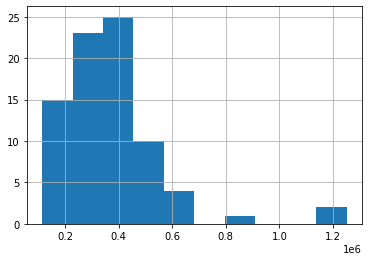

In [40]:
df['price'].hist()

## bed vs bath

<AxesSubplot:xlabel='bed', ylabel='bath'>

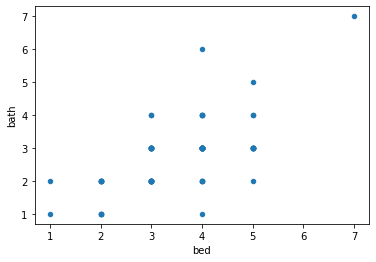

In [41]:
df.plot.scatter(x='bed',y='bath')